In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors, tree, naive_bayes

import seaborn as sns

import re
import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
import gensim


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rawan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rawan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rawan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
columns =["target","id","date", "flag", "user","tweet"]

In [4]:
dataset = pd.read_csv("C:/Users/rawan/OneDrive/Desktop/DePaul/DSC478-ML/final_project/training.1600000.processed.noemoticon.csv",names = columns, encoding = 'latin-1')

In [5]:
dataset.head()

,target,id,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   tweet   1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
dataset.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
tweet     0
dtype: int64

In [8]:
sentiment_counts=dataset["target"].value_counts()
sentiment_counts

0    800000
4    800000
Name: target, dtype: int64

Text(0.5, 1.0, 'Number of tweets for each sentiment')

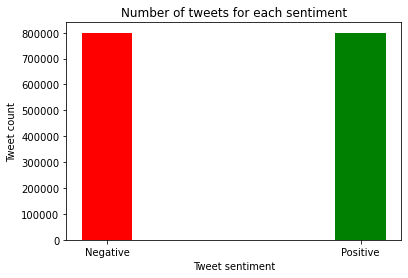

In [9]:
plt.bar(x = sentiment_counts.keys(), 
        height = sentiment_counts.values, color = ['r', 'g'])
plt.xticks([0,4],[ 'Negative', 'Positive'])

plt.xlabel("Tweet sentiment")
plt.ylabel("Tweet count")
plt.title("Number of tweets for each sentiment")


Exploratory analysis on Date

In [10]:
dataset["date"].values

array(['Mon Apr 06 22:19:45 PDT 2009', 'Mon Apr 06 22:19:49 PDT 2009',
       'Mon Apr 06 22:19:53 PDT 2009', ...,
       'Tue Jun 16 08:40:49 PDT 2009', 'Tue Jun 16 08:40:49 PDT 2009',
       'Tue Jun 16 08:40:50 PDT 2009'], dtype=object)

In [11]:
dataset["Day"] = dataset['date'].apply(lambda date: date.split(' ')[0])
dataset["Month"] = dataset['date'].apply(lambda date: date.split(' ')[1])
day_count = dataset["Day"].value_counts()
months_count = dataset["Month"].value_counts()

In [12]:
print(dataset["Month"].unique())

['Apr' 'May' 'Jun']


In [13]:
print(dataset["Day"].unique())

['Mon' 'Tue' 'Fri' 'Sat' 'Sun' 'Wed' 'Thu']


Text(0.5, 1.0, 'Number of tweets for each Month')

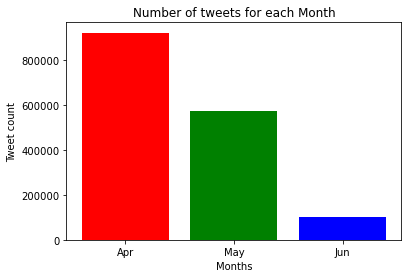

In [14]:
plt.bar(x = dataset["Month"].unique(), 
        height = months_count.values, 
        color = ['r', 'g', 'b'])
plt.xlabel("Months")
plt.ylabel("Tweet count")
plt.title("Number of tweets for each Month")


Text(0.5, 1.0, 'Number of tweets for each Day of a Week')

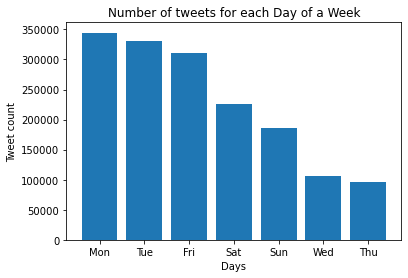

In [15]:
plt.bar(x = dataset["Day"].unique(), 
        height = day_count.values)
plt.xlabel("Days")
plt.ylabel("Tweet count")
plt.title("Number of tweets for each Day of a Week")

In [16]:
dataset = dataset.sample(n=500000)
tweets = list(dataset['tweet'])
sentiment = list(dataset['target'])

Collecting all Hashtags

In [17]:
def hashtag_extract(hashtag):
    hashtags = []
    
    for text in hashtag:
        ht = re.findall(r"#(\w+)", text)
        
        for word in ht:
            ht = []
            word = word.lower()
            word = re.sub(r'[0-9]', '', word)
            word = re.sub(r'\b\w{1,3}\b','', word)
            word = re.sub(' +','', word)
            ht.append(word.strip())
        
        hashtags.append(ht)

    return hashtags

In [18]:
# extracting hashtags from positive tweets
HT_regular = hashtag_extract(dataset['tweet'][dataset['target'] == 4])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(dataset['tweet'][dataset['target'] == 0])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [19]:
dataset["target"].value_counts()

4    250003
0    249997
Name: target, dtype: int64

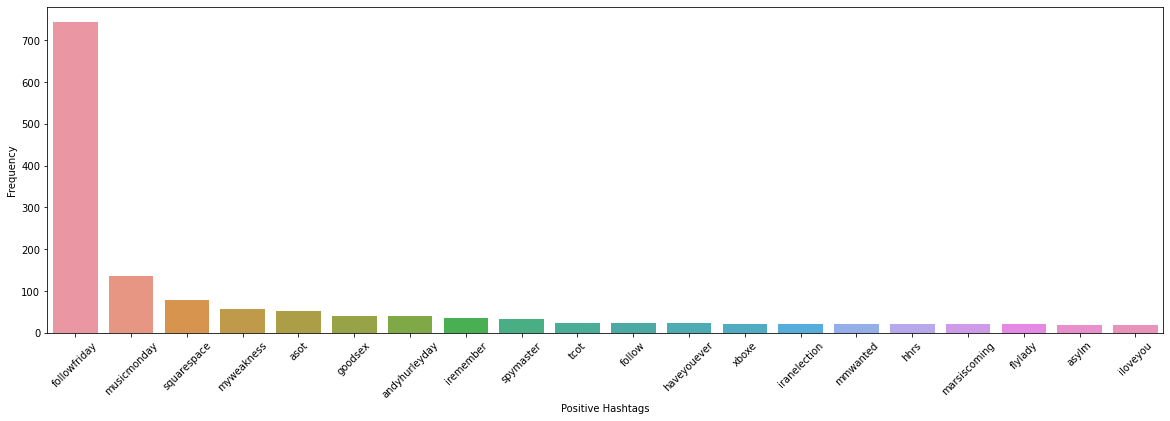

In [20]:
pos_list = nltk.FreqDist(HT_regular)
Pos_hash = pd.DataFrame({'Hashtag': list(pos_list.keys()),
                  'Count': list(pos_list.values())})

# selecting top 20 most frequent hashtags     
# Getting top 21 because the most used has is an empty string
Pos_hash = Pos_hash.nlargest(columns="Count", n = 21)
Pos_hash = Pos_hash[1:21]
plt.figure(figsize=(20,6))
ax = sns.barplot(data=Pos_hash, x= "Hashtag", y = "Count")
ax.set(xlabel = 'Positive Hashtags', ylabel = 'Frequency')
plt.xticks(rotation=45)
plt.show()

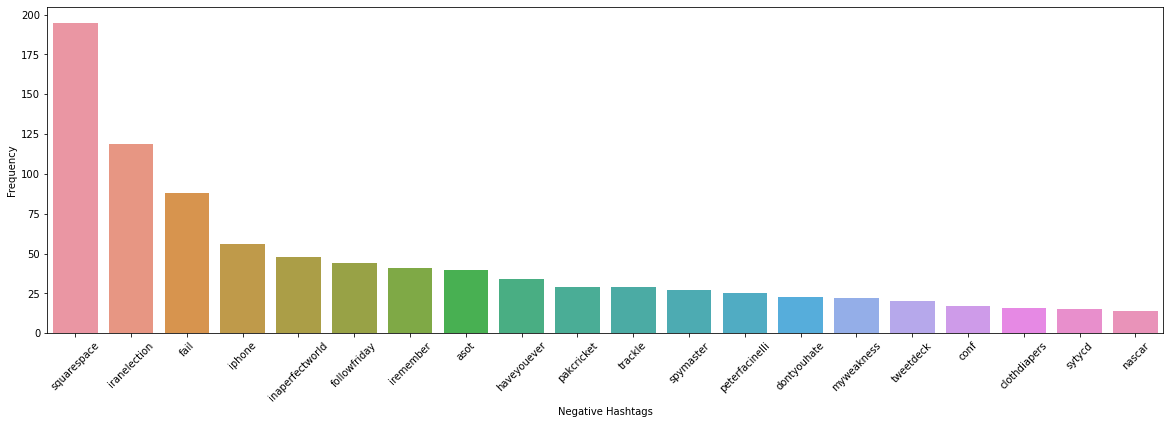

In [21]:
neg_list = nltk.FreqDist(HT_negative)
neg_hash = pd.DataFrame({'Hashtag': list(neg_list.keys()),
                  'Count': list(neg_list.values())})

# selecting top 20 most frequent hashtags     
neg_hash = neg_hash.nlargest(columns="Count", n = 21) 
neg_hash = neg_hash[1:21]
plt.figure(figsize=(20,6))
ax = sns.barplot(data=neg_hash, x= "Hashtag", y = "Count")
ax.set(xlabel ="Negative Hashtags", ylabel = 'Frequency')
plt.xticks(rotation=45)

plt.show()

Exploratory data Analysis on tweets data


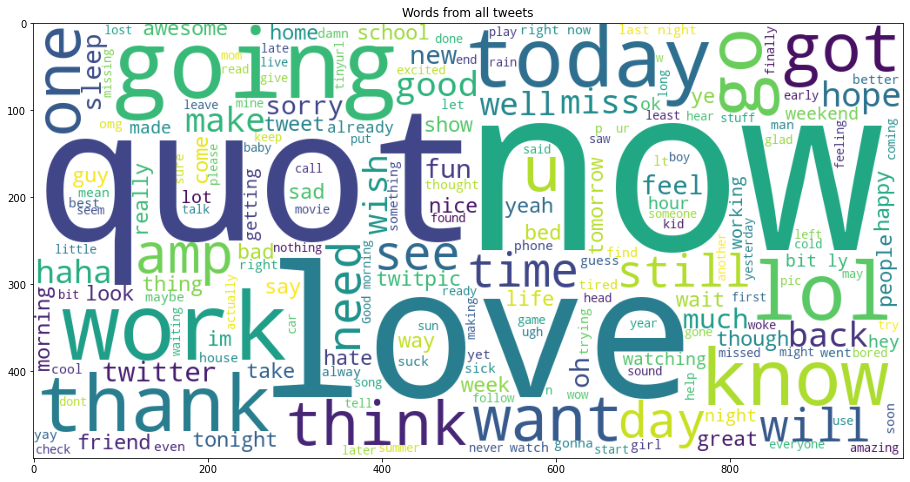

In [22]:
plt.figure(figsize=(20,8))
word_cloud = ""
for row in dataset["tweet"]:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.title("Words from all tweets")
plt.imshow(wordcloud)

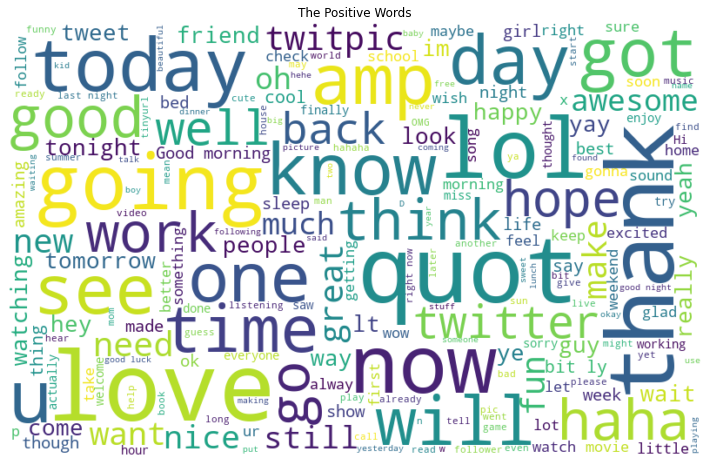

In [23]:
positive_words =' '.join([text for text in dataset['tweet'][dataset['target'] == 4]])

wordcloud = WordCloud(width=800, height=500, background_color ='white', random_state = 0, max_font_size = 110).generate(positive_words)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positive Words')
plt.show()

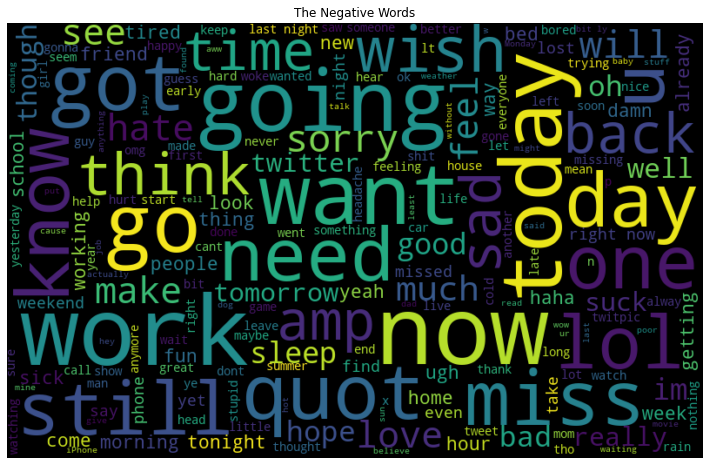

In [24]:
negative_words =' '.join([text for text in dataset['tweet'][dataset['target'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

### Preprocessing of the tweets

In [25]:
stop_words = set(stopwords.words('english'))
stop_words.remove("not")

In [26]:
lemmatizer = WordNetLemmatizer()
porterStemmer = PorterStemmer()

In [27]:
def data_cleaning(data ):
    clean_tweet =[]
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    for tweet in data:
        
        # make all tweets lowercase
        tweet = tweet.lower()
        
        #replace user name(@xxxxx) with an empty string
        tweet = re.sub('@[^\s]+', '', tweet)  
        
        #replace tags(#xxxxx) with an empty string
        tweet = re.sub('#[^\s]+', '', tweet)  
        
        #remove any urls and links
        tweet = re.sub(r"((www\.[^\s]+)|(https?://[^\s]+))", "", tweet)
        
        #remove emojis
        tweet = re.sub(emoji_pattern, "", tweet)
        
        #remove special cahracters
        twet = re.sub('[^a-zA-Z]', '', tweet)
        
        #remove single numberic character
        tweet = re.sub(r'[0-9]', '', tweet)
        
        #remove punctuations
        tweet = re.sub(r'[^\w\s]', '', tweet)
        
        #remove an characters that has length of 1 or 2
        tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
        
        #remove same consecutive letters. eg. heyyyy = hey
        tweet = re.sub(r"(.)\1\1+", r"\1\1", tweet)
        
        # it will remove multiple spaces
        tweet = re.sub(' +', ' ', tweet)

        #an empty string so that we can create a string back from tokenised words
        tweetwords = ''
        
        #tokenising the tweets
        for word in tweet.split():
            
            #removing stop words, lemmetising and stemming the words
            if word not in stop_words:
                root_word = lemmatizer.lemmatize(word)
                tweetwords += (root_word+' ')
                   
        clean_tweet.append(tweetwords)   
    
    return clean_tweet

In [28]:
%%time
processed_tweets=data_cleaning(tweets)


Wall time: 33 s


In [29]:
print(processed_tweets[:50])

['ill accept ', 'hope get wood work done weekend next week lasagna friend lillie without ', 'school francisco jomar trystin like quotjasonquot eeww ', 'moved ', 'follow friday come follow ', 'tired getting bed gotta work already know going hard get night ', 'lol literally mean hotsauce took swing hill quothell hath fury like woman scornedquot bottle ', 'yup ', 'good luck sure spectacular ', 'hoping croaky voice would better sleep seems not well sure itll better wembley ', 'heck yes ', 'hows wembley hometown miss place ', 'lve pacock dress ', 'still hope everything getting bit nasty supposed conference got canceled bcoz flu ', 'massive headache ', 'cant sleep reason going forty second hour without sleep ', 'hahaa got much hate uhhm make bracelet duddee actually needa get bead ', 'wonderfully awesome day outside little foggy work inside today ', 'know currently period dont blame ', 'suck cant wait summer tell truth absoutely idea ', 'wondering ill get inmed letter wednesday lil dog keep 

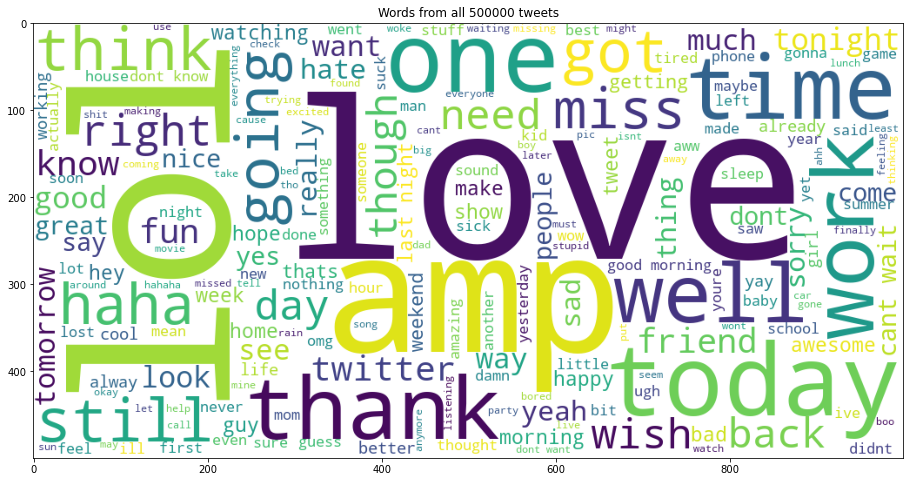

In [30]:
plt.figure(figsize=(20,8))
word_cloud = ""
for row in processed_tweets:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.title("Words from all 500000 tweets")
plt.imshow(wordcloud)

In [31]:
# tokenizing the words present in the training set
tokenized_tweet = list(map(lambda x: x.split(), processed_tweets[:250000])) 

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(processed_tweets[:250000]), epochs=20)

(29940875, 33824000)

In [32]:
model_w2v.wv.most_similar(positive = "music")


[('song', 0.5188702344894409),
 ('famp', 0.5145664215087891),
 ('dilla', 0.5049906373023987),
 ('remixes', 0.5030019879341125),
 ('calle', 0.4964962601661682),
 ('mutemath', 0.48041194677352905),
 ('listen', 0.4760019779205322),
 ('beatport', 0.4692753255367279),
 ('trainwreck', 0.4687798321247101),
 ('enya', 0.46199071407318115)]

In [33]:
model_w2v.wv.most_similar(positive = "food")


[('poisoning', 0.5519200563430786),
 ('keila', 0.5319811105728149),
 ('loafin', 0.5247848033905029),
 ('nyu', 0.5086788535118103),
 ('enchilada', 0.5070486664772034),
 ('chopstick', 0.5019416213035583),
 ('prati', 0.49539995193481445),
 ('hungry', 0.4910382926464081),
 ('hacienda', 0.4909260869026184),
 ('nightmy', 0.4893318712711334)]

In [34]:
model_w2v.wv.most_similar(negative = "work")


[('rthx', 0.09041490405797958),
 ('rainingrainingraining', 0.0586930513381958),
 ('doente', 0.04175439476966858),
 ('acaabou', 0.040360212326049805),
 ('artk', 0.0001402307243552059),
 ('ronery', -0.018063902854919434),
 ('helou', -0.026692522689700127),
 ('ver', -0.028684692457318306),
 ('alice', -0.029375433921813965),
 ('tribute', -0.030966345220804214)]

In [35]:
model_w2v.wv.most_similar(negative = "love")


[('rthx', 0.09791339933872223),
 ('helou', 0.07788783311843872),
 ('micro', 0.026414379477500916),
 ('doente', 0.025961661711335182),
 ('rainingrainingraining', 0.016838937997817993),
 ('employee', 0.009893879294395447),
 ('lan', -0.0045992047525942326),
 ('pharmacy', -0.011255818419158459),
 ('diagnosis', -0.012882933020591736),
 ('cabinet', -0.013991696760058403)]

## Spitting testing and training dataset

In [36]:
#X_train, X_test, Y_train,Y_test = train_test_split(dataset,0.8)
x_train, x_test, y_train, y_test = train_test_split (processed_tweets, dataset.iloc[:,0],test_size =0.1, random_state = 33)


In [37]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [38]:
print("x_train:",x_train.shape)
print("x_test: ",x_test.shape)
print("y_train:",y_train.shape)
print("y_test: ",y_test.shape)


x_train: (450000,)
x_test:  (50000,)
y_train: (450000,)
y_test:  (50000,)


In [39]:
print(y_train)

[0 0 0 ... 0 0 0]


# TF-IDF Vectiorising

In [40]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)


In [41]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(x_test)
print(f'Vectoriser fitted to Testing Dataset.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted to Testing Dataset.
No. of feature_words:  248422


In [42]:
x_train = vectoriser.transform(x_train)
x_test  = vectoriser.transform(x_test)
print(f'Data Transformed.')

Data Transformed.


# Building a Model

Our dataset is not baised. It has equal number of both positive and negatives sentiments

# Model Evaluation

In [46]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(x_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(cf_matrix)
    
    accuracy = model.score(x_test, y_test)
    print(accuracy)



# Logistic Regression

In [ ]:
LR_basemodel = LogisticRegression(max_iter = 1000)
LR_basemodel.fit(x_train, y_train)
model_Evaluate(LR_basemodel)

Hyper parameter tuning for Logistic regression


In [ ]:
LR_model = LogisticRegression(max_iter = 100000)
penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(penalty=penalty,C=c_values)
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle = True)
grid_search = GridSearchCV(estimator=LR_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
LR = LogisticRegression(C = 100, penalty = 'l2', solver = 'newton-cg')
LR = LR.fit(x_train[:500,:], y_train[:500])

In [ ]:
model_Evaluate(LR)

We just decided to go with baseline Logistic regressign which gives accuracy of 0.8.

In [ ]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(x_train, y_train)
model_Evaluate(BNBmodel)

In [ ]:
DTmodel = tree.DecisionTreeClassifier()
DTmodel.fit(x_train, y_train)

In [ ]:
Model_Evaluate(DTmodel)

# KNN

In [ ]:
knnmodel = neighbors.KNeighborsClassifier(3, weights='distance')
knnmodel.fit(x_train, y_train)

In [ ]:
knnmodel.predict(x_test)

In [ ]:
accuracy = knnmodel.score(x_test, y_test)
print(accuracy)

# Using Rocchio method of KNN, which is Nearest Centroid

In [ ]:
from sklearn.neighbors import NearestCentroid
clf = NearestCentroid()
clf.fit(x_train, y_train)
NearestCentroid()

In [ ]:
prediction = clf.predict(x_test)

In [ ]:
model_Evaluate(clf)

In [ ]:
print("ah")

# Using Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, verbose=3,n_jobs=-1, criterion = 'entropy')
#rf = RandomForestClassifier(n_estimators = 10, criteri b  on = 'entropy', random_state = 0)
rf.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100

building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 48.0min


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 235.0min finished


RandomForestClassifier(criterion='entropy', n_jobs=-1, verbose=3)

In [59]:
model_Evaluate(rf)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   31.6s finished


              precision    recall  f1-score   support

           0       0.78      0.77      0.77     25227
           4       0.77      0.78      0.77     24773

    accuracy                           0.77     50000
   macro avg       0.77      0.77      0.77     50000
weighted avg       0.77      0.77      0.77     50000

[[19386  5841]
 [ 5497 19276]]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    8.5s


0.77324


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   28.4s finished
